In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Input,Dense, Dropout
from keras.models import Model,Sequential, load_model
from sklearn.metrics import roc_curve, auc
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score,adjusted_rand_score,average_precision_score,v_measure_score, completeness_score, homogeneity_score, silhouette_score,roc_curve, auc, f1_score, precision_recall_curve, precision_score,recall_score,accuracy_score,confusion_matrix
import sys
from sklearn.linear_model import LogisticRegression
sys.path.append('/Users/chenpete/Documents/ESP/practicum/autoencoders/code')
from sklearn.model_selection import KFold
from utils import * 
from sklearn.neighbors import BallTree
from sklearn.manifold import TSNE

Using TensorFlow backend.


### Link to Paper

https://arxiv.org/pdf/1809.10717.pdf

In [83]:
DATA_DIR = '/Users/PeterC/Documents/gt/practicum/autoencoders/data/'
DATA_DIR = '/Users/chenpete/Documents/ESP/practicum/autoencoders/data/'

non_scale_cols = ['time','y_early','y_rank','y']
param_cols = [
        'x1', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       'x10', 'x11', 'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19',
       'x20', 'x21', 'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29',
       'x30', 'x31', 'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39',
       'x40', 'x41', 'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49',
       'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59',
       'x60']

y_col = 'y_early'
early_step = 4

df = pd.read_csv(DATA_DIR + 'paper_mill_rare_events.csv')
df['time'] = pd.to_datetime(df['time'])
X_train, X_test, y_train, y_test,y_rank_train, y_rank_test = preprocess_data(df,param_cols,y_col, non_scale_cols,early_step,test_size = .1)

# Model 1: Layer autoencoder

In [36]:
model = Sequential()
model.add(Dense(units = 32,activation='relu',input_shape = (len(param_cols),)))
model.add(Dense(units = 16,activation='relu'))
model.add(Dense(units = 32,activation='relu'))
model.add(Dense(units = len(param_cols),activation='linear'))
model.compile(optimizer='adam', loss='mse')

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 32)                1920      
_________________________________________________________________
dense_7 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_8 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_9 (Dense)              (None, 59)                1947      
Total params: 4,939
Trainable params: 4,939
Non-trainable params: 0
_________________________________________________________________


Epoch 1/50
16007/16007 [==============================] - 1s 79us/step - loss: 0.3787
Epoch 2/50
16007/16007 [==============================] - 1s 66us/step - loss: 0.1928
Epoch 3/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.1613
Epoch 4/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.1428
Epoch 5/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.1293
Epoch 6/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.1191
Epoch 7/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.1120
Epoch 8/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.1066
Epoch 9/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.1022
Epoch 10/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.0991
Epoch 11/50
16007/16007 [==============================] - 1s 67us/step - loss: 0.0963
Epoch 12/50
16007/16007 [===========================

Text(0.5, 1.0, 'loss history')

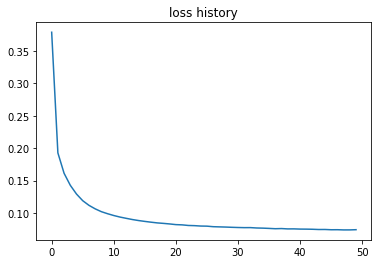

In [37]:
history_callback = model.fit(X_train,X_train,epochs=50,batch_size = 12)
loss_history = history_callback.history['loss']
plt.plot(loss_history)
plt.title('loss history')

In [38]:
#model = load_model('autoencoder_32_16_32.h5')
model.save('autoencoder_32_16_32.h5')

In [39]:
X_pred_test = model.predict(X_test)

X_pred_train = model.predict(X_train)

df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test)
df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train)

In [40]:
nominal_idx = y_rank_test==0
early1_idx = y_rank_test==1
early2_idx = y_rank_test==2
early3_idx = y_rank_test==3
early4_idx = y_rank_test==4

## Assess errors for each time lag

In [41]:
res_nominal_train = df_results_train[df_results_train['y'] == 0]['residual_avg']

average_res_nominal_train = np.mean(res_nominal_train)
std_res_nominal_train = np.std(res_nominal_train)
threshold_3s = average_res_nominal_train + 3*std_res_nominal_train
threshold_5s = average_res_nominal_train + 5*std_res_nominal_train
threshold_max = np.max(res_nominal_train)

threshold_list = [('3s',threshold_3s),('5s',threshold_5s),('max',threshold_max)]

### Training residuals

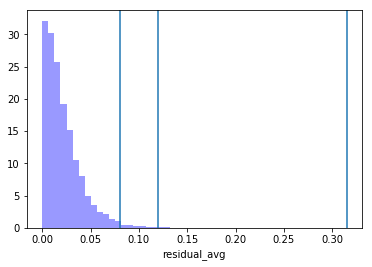

In [43]:
plt.figure()
sns.distplot(df_results_train['residual_avg'],norm_hist=True,kde=False,color='blue')
for threshold_name,threshold in threshold_list:
    plt.axvline(threshold)


------------------ early time step of 1----------------------------


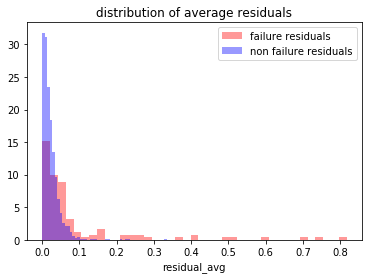

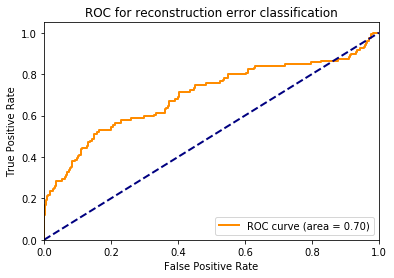

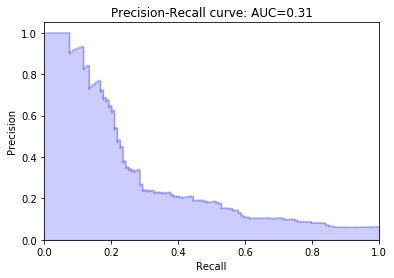



------ Using threshold 3s---------------
accuracy = 0.935
precision = 0.466
recall = 0.227
f1 = 0.305


------ Using threshold 5s---------------
accuracy = 0.944
precision = 0.688
recall = 0.185
f1 = 0.291


------ Using threshold max---------------
accuracy = 0.942
precision = 0.900
recall = 0.076
f1 = 0.140

------------------ early time step of 2----------------------------


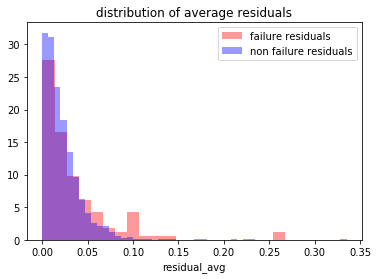

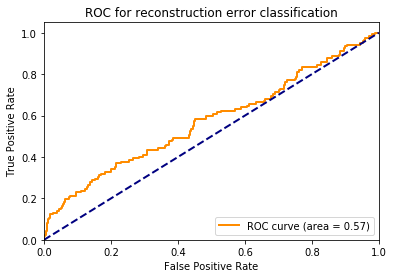

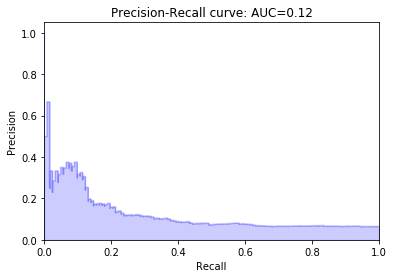



------ Using threshold 3s---------------
accuracy = 0.927
precision = 0.311
recall = 0.115
f1 = 0.168


------ Using threshold 5s---------------
accuracy = 0.933
precision = 0.286
recall = 0.033
f1 = 0.059


------ Using threshold max---------------
accuracy = 0.935
precision = 0.000
recall = 0.000
f1 = 0.000

------------------ early time step of 3----------------------------


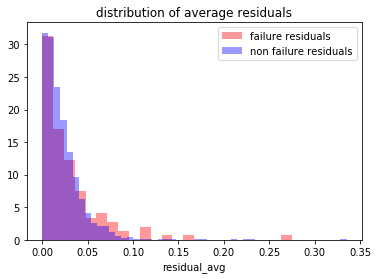

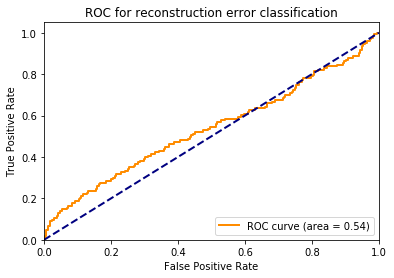

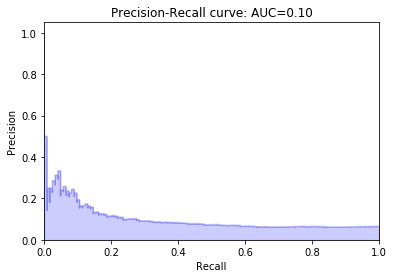



------ Using threshold 3s---------------
accuracy = 0.924
precision = 0.225
recall = 0.073
f1 = 0.110


------ Using threshold 5s---------------
accuracy = 0.932
precision = 0.231
recall = 0.024
f1 = 0.044


------ Using threshold max---------------
accuracy = 0.935
precision = 0.000
recall = 0.000
f1 = 0.000

------------------ early time step of 4----------------------------


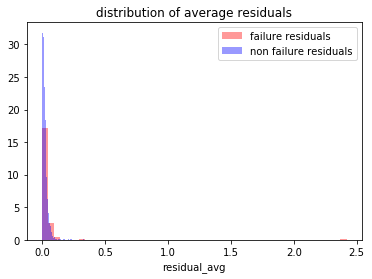

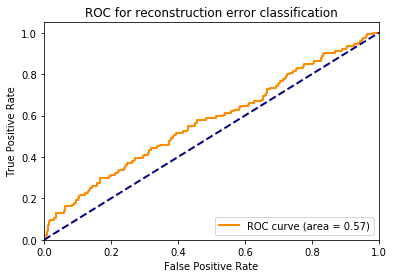

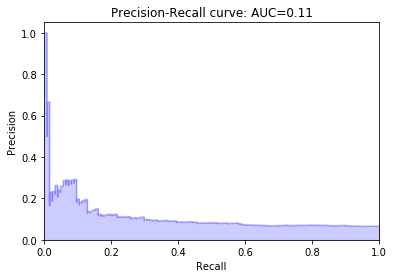



------ Using threshold 3s---------------
accuracy = 0.925
precision = 0.279
recall = 0.097
f1 = 0.144


------ Using threshold 5s---------------
accuracy = 0.931
precision = 0.167
recall = 0.016
f1 = 0.029


------ Using threshold max---------------
accuracy = 0.935
precision = 0.500
recall = 0.008
f1 = 0.016


In [44]:
for rank in range(1,np.max(df_results_test['y_rank'])):
    
    print('\n------------------ early time step of {}----------------------------'.format(rank))
    
    df_results_rank= df_results_test[(df_results_test['y_rank']==rank) | (df_results_test['y_rank']==0)]
    res_nominal_test = df_results_rank[df_results_rank['y'] == 0]['residual_avg']
    res_failures_test = df_results_rank[df_results_rank['y'] != 0]['residual_avg']
    
    plt.figure()
    sns.distplot(res_failures_test,norm_hist=True,kde=False,color='red')
    sns.distplot(res_nominal_test,norm_hist=True,kde=False,color='blue')
    plt.legend(['failure residuals','non failure residuals'])
    plt.title('distribution of average residuals')

    y_true = np.array(df_results_rank['y'])
    y_pred_proba = np.array(df_results_rank['residual_avg']/np.max(df_results_rank['residual_avg']))

    plot_roc(y_true,y_pred_proba)
    plot_pr_curve(y_true,y_pred_proba)
    
    for name,threshold in threshold_list:
        print('\n\n------ Using threshold {}---------------'.format(name))
        y_pred_threshold = np.where(df_results_rank['residual_avg'] > threshold, 1, 0)
        
        print('accuracy = {:.3f}'.format(accuracy_score(y_true,y_pred_threshold)))
        print('precision = {:.3f}'.format(precision_score(y_true,y_pred_threshold)))
        print('recall = {:.3f}'.format(recall_score(y_true,y_pred_threshold)))
        print('f1 = {:.3f}'.format(f1_score(y_true,y_pred_threshold)))


(0, 0.75)

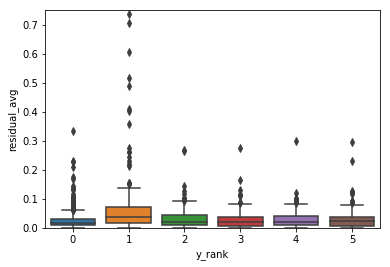

In [45]:
sns.boxplot(x='y_rank',y='residual_avg',data=df_results_test)
plt.ylim((0,.75))

# Try different ways to analyze reconstruction error

In [233]:
residuals_test = X_pred_test - X_test
residuals_train = X_pred_train - X_train

early_idx = early3_idx

residuals_test = residuals_test[nominal_idx |early_idx]
y_test_early = y_test[nominal_idx |early_idx]

### Try std error 

In [234]:
residuals_train_mean = np.abs(np.mean(residuals_train,axis=1))
residuals_train_std = np.std(residuals_train,axis=1)

std_threshold = np.std(residuals_train_std) + 3*np.std(residuals_train_std)
std_threshold

0.40368163130260093

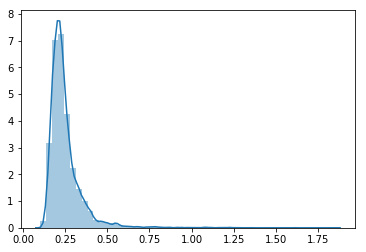

In [235]:
sns.distplot(residuals_train_std)

In [236]:
residuals_test_mean = np.abs(np.mean(residuals_test,axis=1))
residuals_test_std = np.std(residuals_test,axis=1)

Text(0.5, 1.0, 'distribution of std residual')

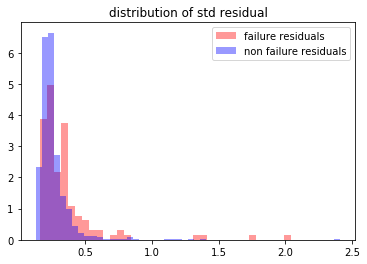

In [237]:
plt.figure()
sns.distplot(residuals_test_std[early_idx],norm_hist=True,kde=False,color='red')
sns.distplot(residuals_test_std[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of std residual')

In [238]:
y_pred_proba_std = residuals_test_std/np.max(residuals_test_std)

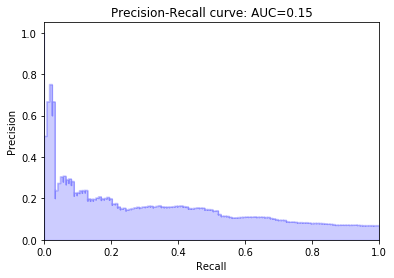

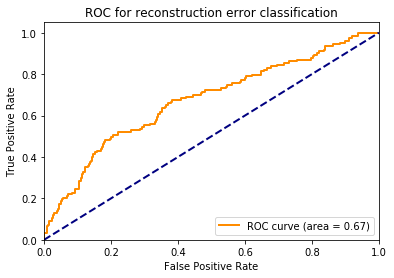

In [239]:
plot_pr_curve(y_test_early,y_pred_proba_std)
plot_roc(y_test_early,y_pred_proba_std)

In [240]:
y_pred_threshold_std = np.where(residuals_test_std > std_threshold, 1, 0)

print('accuracy = {:.3f}'.format(accuracy_score(y_test_early,y_pred_threshold_std)))
print('precision = {:.3f}'.format(precision_score(y_test_early,y_pred_threshold_std)))
print('recall = {:.3f}'.format(recall_score(y_test_early,y_pred_threshold_std)))
print('f1 = {:.3f}'.format(f1_score(y_test_early,y_pred_threshold_std)))

accuracy = 0.896
precision = 0.195
recall = 0.195
f1 = 0.195


### Look at all errors

## KNN on reconstruction error

In [276]:
from sklearn.neighbors import DistanceMetric
#dm = DistanceMetric.get_metric('mahalanobis', V=np.cov(residuals_train))
tree = BallTree(residuals_train,metric ='euclidean')

In [292]:
dist,ind = tree.query(residuals_test,k=1)
dist = np.mean(dist,axis=1)
dist = pd.Series(dist.ravel(),index=residuals_test.index)

Text(0.5, 1.0, 'distribution of L2 distance for residual')

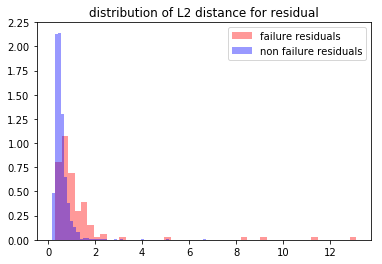

In [293]:
plt.figure()
sns.distplot(dist[early_idx],norm_hist=True,kde=False,color='red')
sns.distplot(dist[nominal_idx],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of L2 distance for residual')

In [294]:
threshold_distance = np.mean(dist[nominal_idx]) + 2*np.std(dist[nominal_idx])
threshold_distance

1.2297169665233383

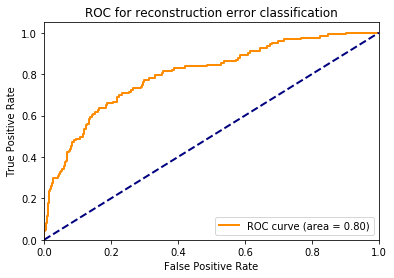

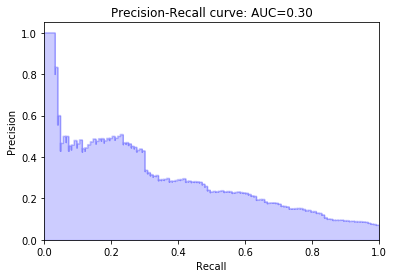

In [295]:
y_pred_proba_knn = dist/np.max(dist)
plot_roc(y_test_early,y_pred_proba_knn)
plot_pr_curve(y_test_early,y_pred_proba_knn)

In [296]:
y_pred_threshold_knn = np.where(dist > 5.2, 1, 0)
print('accuracy = {:.3f}'.format(accuracy_score(y_test_early,y_pred_threshold_knn)))
print('precision = {:.3f}'.format(precision_score(y_test_early,y_pred_threshold_knn)))
print('recall = {:.3f}'.format(recall_score(y_test_early,y_pred_threshold_knn)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_test_early,y_pred_threshold_knn)))
print(confusion_matrix(y_test_early,y_pred_threshold_knn))

accuracy = 0.937
precision = 0.800
recall = 0.033
f1 = 0.063


[[1778    1]
 [ 119    4]]


# Cross Validation for KNN

In [30]:
# K = 10
# X_train_list, X_test_list, y_train_list, y_test_list,y_rank_train_list, y_rank_test_list = preprocess_data_cv(df,param_cols,y_col, non_scale_cols,early_step, k = K)

In [31]:
# for k in range(K):
    
#     X_train, y_train, y_rank_train = X_train_list[k],y_train_list[k],y_rank_train_list[k]
#     X_test, y_test, y_rank_test = X_test_list[k],y_test_list[k],y_rank_test_list[k]
    
#     nominal_idx = y_rank_test==0
#     early1_idx = y_rank_test==1
    
#     model = simple_ann_autoencoder_regression(param_cols,32,16,32)
#     history_callback = model.fit(X_train,X_train,epochs=75,batch_size = 32,verbose = 0)
    
#     X_pred_test = model.predict(X_test)
#     X_pred_train = model.predict(X_train)

#     df_results_test = results_df(X_test,X_pred_test,y_test,y_rank_test)
#     df_results_train = results_df(X_train,X_pred_train,y_train,y_rank_train)
    
#     residuals_test = X_pred_test - X_test
#     residuals_train = X_pred_train - X_train
    
#     residuals_test = residuals_test[nominal_idx |early1_idx]
#     y_test_early1 = y_test[nominal_idx |early1_idx]
    
#     tree = BallTree(residuals_train)
    
#     dist,ind = tree.query(residuals_test,k=1)
#     dist = pd.Series(dist.ravel(),index=residuals_test.index)
    
#     y_pred_proba_knn = dist/np.max(dist)
#     plot_roc(y_test_early1,y_pred_proba_knn)

# Try Logistic Regression on reconstruction error

/Users/chenpete/Documents/code/DL/dlenv/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


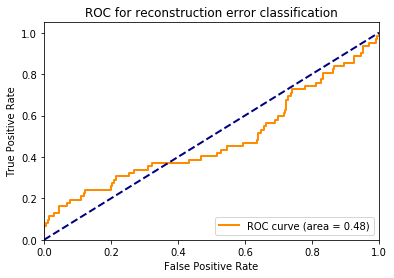

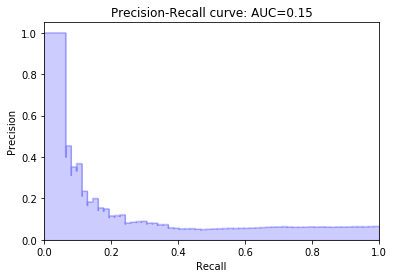

Text(0.5, 1.0, 'distribution of logistic regression probability')

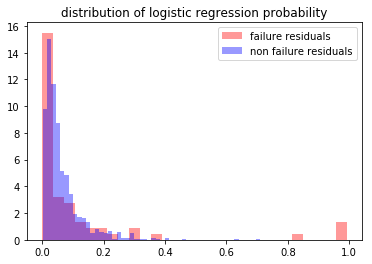

In [141]:
X_residual_train, X_residual_test, y_residual_train, y_residual_test = train_test_split(residuals_test, y_test_early, test_size=0.5
                                                                                        , random_state=0, stratify = y_test_early)

clf = LogisticRegression()
clf.fit(X_residual_train,y_residual_train)
y_pred_logreg_proba = clf.predict_proba(X_residual_test)[:,1]

plot_roc(y_residual_test,y_pred_logreg_proba)
plot_pr_curve(y_residual_test,y_pred_logreg_proba)

plt.figure()
sns.distplot(y_pred_logreg_proba[y_residual_test==1],norm_hist=True,kde=False,color='red')
sns.distplot(y_pred_logreg_proba[y_residual_test==0],norm_hist=True,kde=False,color='blue')
plt.legend(['failure residuals','non failure residuals'])
plt.title('distribution of logistic regression probability')

In [142]:
y_pred_threshold_logreg = np.where(y_pred_logreg_proba > .25, 1, 0)

print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_threshold_logreg)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_threshold_logreg)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_threshold_logreg)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_threshold_logreg)))
print(confusion_matrix(y_residual_test,y_pred_threshold_logreg))

accuracy = 0.918
precision = 0.233
recall = 0.113
f1 = 0.152


[[867  23]
 [ 55   7]]


# Try decision tree on reconstruction error

In [105]:
from sklearn.tree import DecisionTreeClassifier

clf_dt = DecisionTreeClassifier()
clf_dt.fit(X_residual_train,y_residual_train)
y_pred_dt = clf_dt.predict(X_residual_test)

print('accuracy = {:.3f}'.format(accuracy_score(y_residual_test,y_pred_dt)))
print('precision = {:.3f}'.format(precision_score(y_residual_test,y_pred_dt)))
print('recall = {:.3f}'.format(recall_score(y_residual_test,y_pred_dt)))
print('f1 = {:.3f}\n\n'.format(f1_score(y_residual_test,y_pred_dt)))
print(confusion_matrix(y_residual_test,y_pred_dt))

accuracy = 0.893
precision = 0.100
recall = 0.081
f1 = 0.090


[[507  27]
 [ 34   3]]


## T-sne on reconstruction errors

perplexity_list = [5,20,45]

for p in perplexity_list:
    tsne = TSNE(n_components=2,perplexity=p)
    tsne_output = tsne.fit_transform(residuals_test)
    tsne_output1 = pd.Series(tsne_output[:,0],index=residuals_test.index)
    tsne_output2 = pd.Series(tsne_output[:,1],index=residuals_test.index)

    plt.figure(figsize=(8,8))
    plt.scatter(tsne_output1[nominal_idx],tsne_output2[nominal_idx],color='blue')
    plt.scatter(tsne_output1[early1_idx],tsne_output2[early1_idx],color='red')
    plt.legend(['nonfailure','early1'])
    plt.title('tsne plot 1 vs 2, perplexity = {}'.format(p))